Import Modules

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Load the Dataset

In [40]:
df = pd.read_csv("AirPassengers.csv")

Exploratory Data Analysis

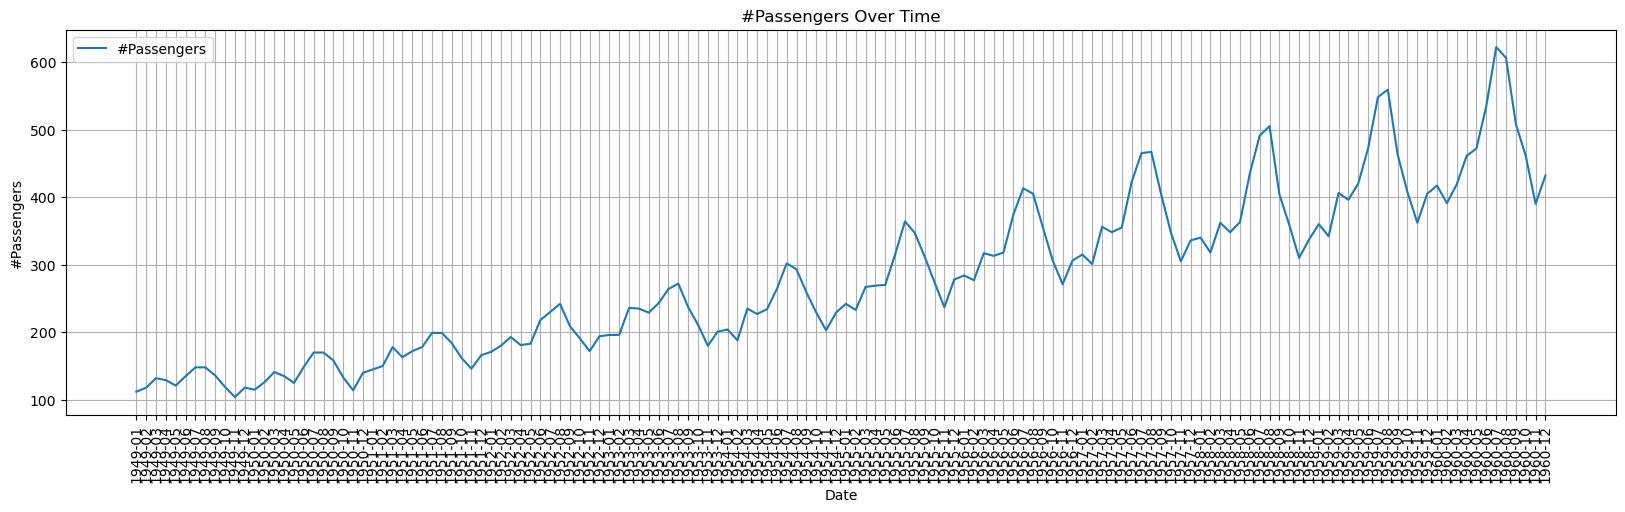

In [10]:
plt.figure(figsize=(20,5))
plt.plot(df.index, df['#Passengers'], label='#Passengers')
plt.xlabel('Date')
plt.ylabel('#Passengers')
plt.title('#Passengers Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=90)
plt.show()

In [11]:
# perform seasonal decomposition
result = seasonal_decompose(df['#Passengers'],model='mulitplicative',period=12)

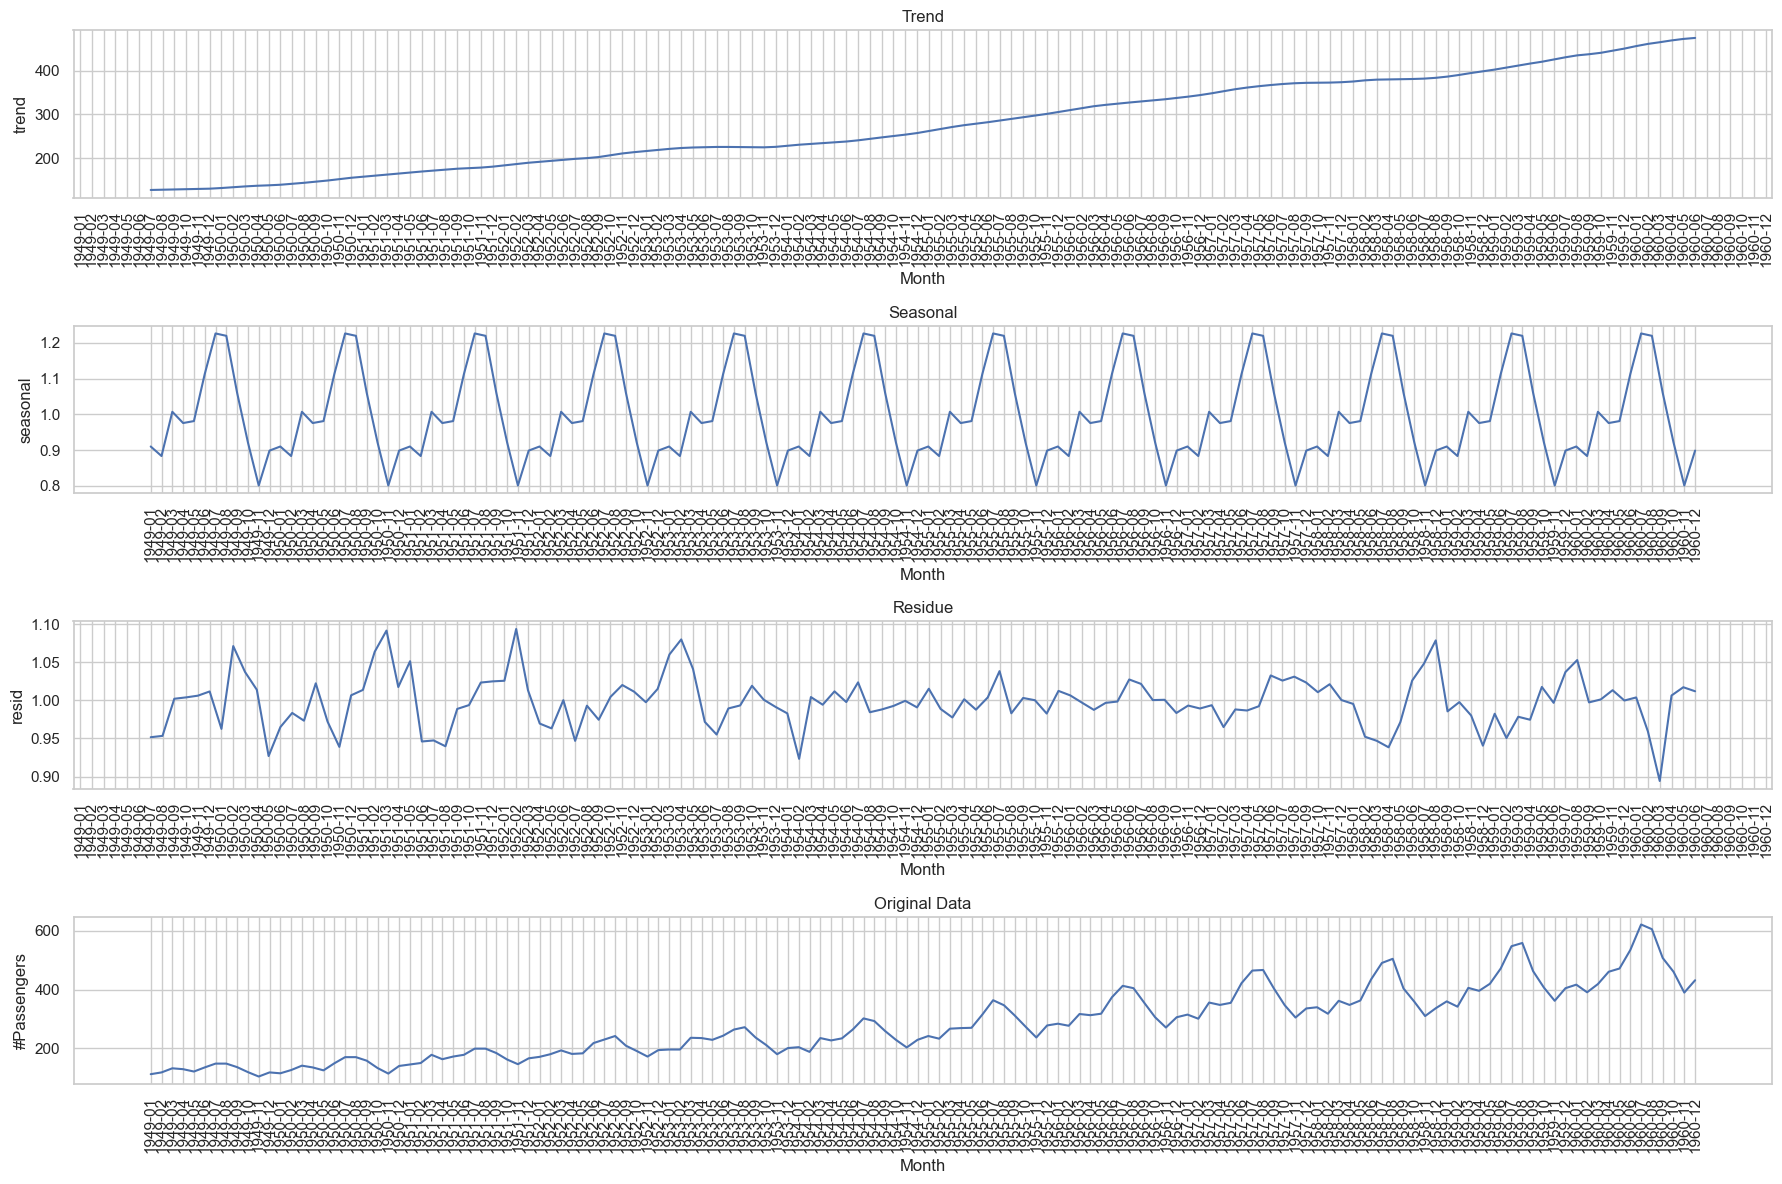

In [13]:
#plot components in graph
sns.set(style='whitegrid')

plt.figure(figsize=(18,12))

#Trend component
plt.subplot(411)
sns.lineplot(data=result.trend)
plt.title('Trend')
plt.xticks(rotation=90)

# seasonal component
plt.subplot(412)
sns.lineplot(data=result.seasonal)
plt.title('Seasonal')
plt.xticks(rotation=90)

# Residual component
plt.subplot(413)
sns.lineplot(data=result.resid)
plt.title('Residue')
plt.xticks(rotation=90)

# Original Data
plt.subplot(414)
sns.lineplot(data=df['#Passengers'])
plt.title('Original Data')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [14]:
seasonal_period = 12


In [15]:
from statsmodels.tsa.stattools import adfuller 

result = adfuller(df['#Passengers'], autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.8153688792060597
p-value: 0.9918802434376411


In [16]:
# first order differencing 
result = adfuller(df['#Passengers'].diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.829266824169992
p-value: 0.0542132902838265


In [17]:
# second order differencing 
result = adfuller(df['#Passengers'].diff().diff().dropna(), autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -16.384231542468527
p-value: 2.732891850014085e-29


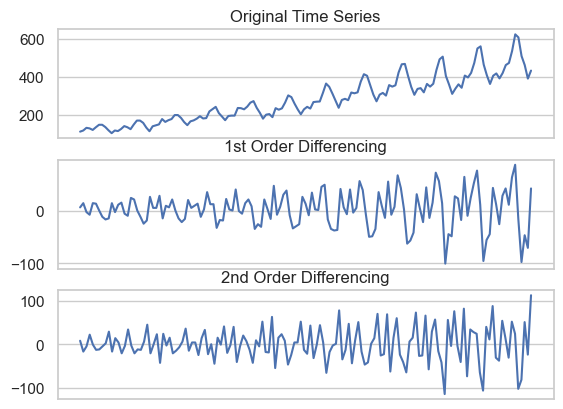

In [19]:
#plot the differencing values
fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(df)
ax1.set_title('Original Time Series')
ax1.axes.xaxis.set_visible(False)

ax2.plot(df.diff())
ax2.set_title('1st Order Differencing')
ax2.axes.xaxis.set_visible(False)

ax3.plot(df.diff().diff())
ax3.set_title('2nd Order Differencing')
ax3.axes.xaxis.set_visible(False)

plt.show()

Define Parameters forARIMA

In [20]:
#p = 0 #MA moving average
#d = 1 #order of differencing
#q = 0 #Auto Regressive

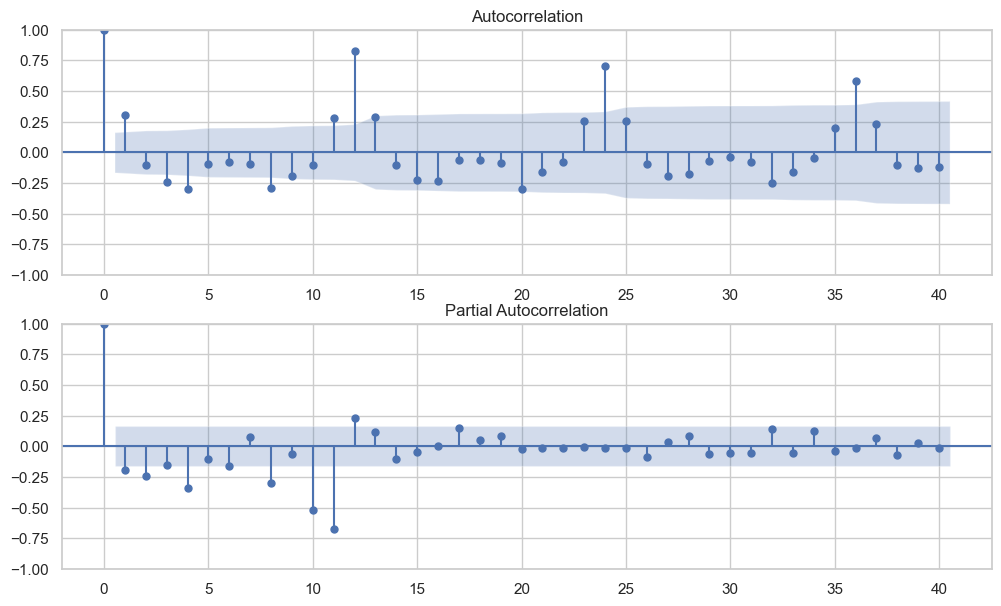

In [21]:
fig, ax = plt.subplots(2,1, figsize=(12,7))
sm.graphics.tsa.plot_acf(df.diff().dropna(), lags=40, ax=ax[0])
sm.graphics.tsa.plot_pacf(df.diff().diff().dropna(), lags=40, ax=ax[1])
plt.show()

In [22]:

p = 2 # pacf
d = 1 # 1st order difference
q = 1 # acf

In [23]:

P = 1
D = 0
Q = 3

In [25]:
#MODEL TRAINING
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(df['#Passengers'], order=(p,d,q), seasonal_order=(P,D,Q,seasonal_period))
fitted_model = model.fit()
print(fitted_model.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2, 3], 12)   Log Likelihood                -563.224
Date:                                    Mon, 30 Jun 2025   AIC                           1142.448
Time:                                            13:35:52   BIC                           1166.151
Sample:                                        01-01-1949   HQIC                          1152.080
                                             - 12-01-1960                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6247      0.101      6.170      0

In [28]:
#Forecast for the next 2 years
forecast_steps = 24
forecast = fitted_model.get_forecast(steps=forecast_steps)

#create the date range for the forecasted values
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_steps+1, freq='M')[1:].strftime('%Y-%m')

In [31]:
#create a forecast dataframe
forecast_df = pd.DataFrame({
    "Forecast": list(forecast.predicted_mean),
    "Lower CI": list(forecast.conf_int().iloc[:,0]),
    "Upper CI": list(forecast.conf_int().iloc[:,1])
}, index = forecast_index)
forecast_df.head()

,Forecast,Lower CI,Upper CI
1961-01,446.728132,424.884418,468.571845
1961-02,423.354516,397.217023,449.492009
1961-03,456.481533,426.865410,486.097657
1961-04,491.604168,459.572999,523.635336
1961-05,505.178266,471.297560,539.058971


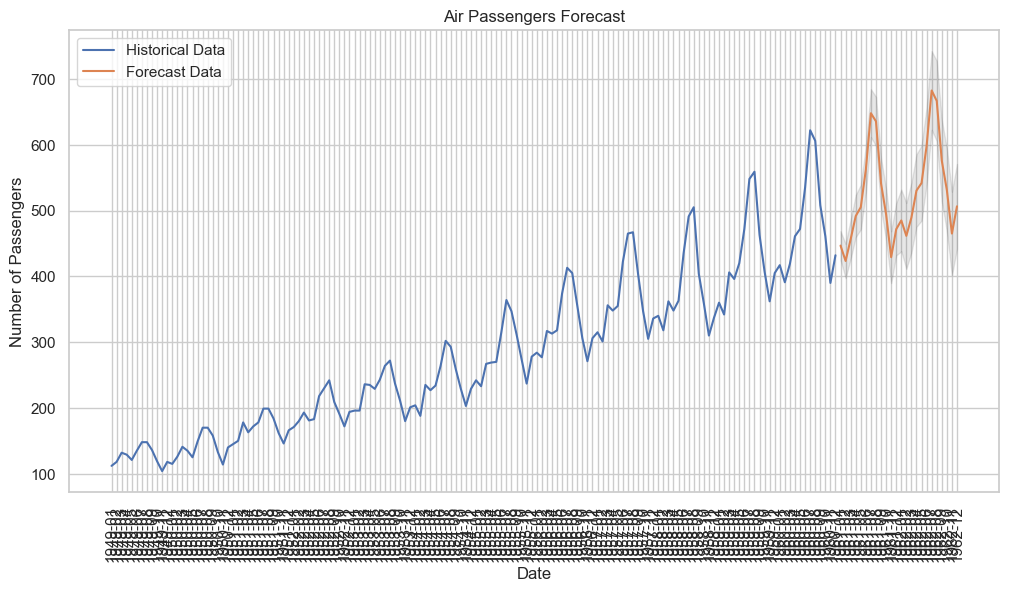

In [36]:
# plot the forecast values

plt.figure(figsize=(12,6))
plt.plot(df['#Passengers'], label = 'Historical Data')
plt.plot(forecast_df['Forecast'], label = 'Forecast Data')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'],forecast_df['Upper CI'],color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.title('Air Passengers Forecast')
plt.xticks(rotation=90)
plt.legend()
plt.show()

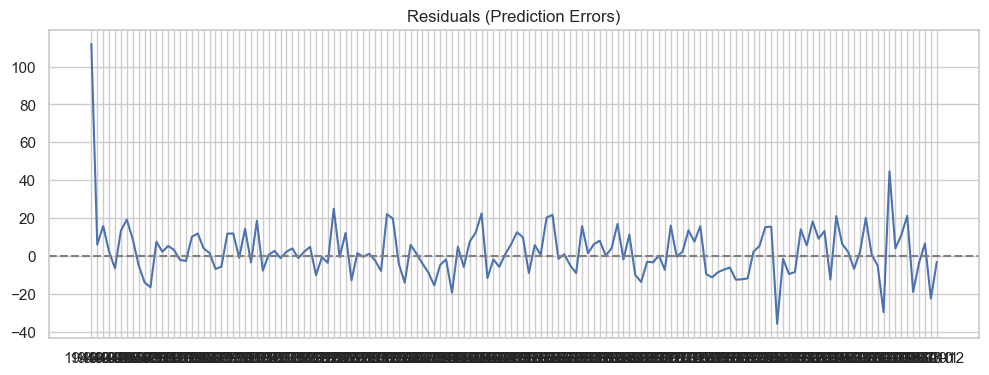

In [37]:
residuals = fitted_model.resid
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals (Prediction Errors)')
plt.axhline(y=0, linestyle='--', color='gray')
plt.show()


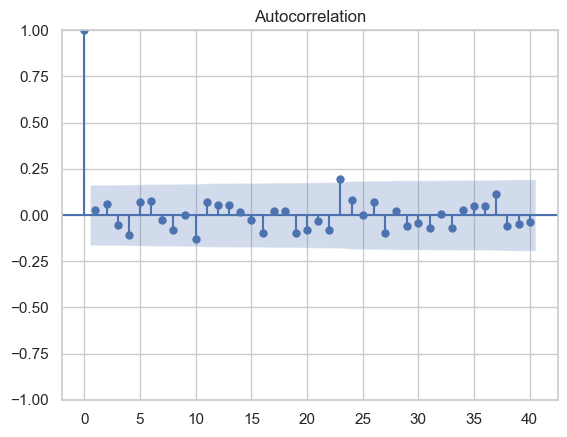

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals.dropna(), lags=40)
plt.show()
